In [3]:
using Plots, Distributions, LinearAlgebra, DelimitedFiles
gr(fmt = "png")

Plots.GRBackend()

Funciones auxiliares y algunas estructuras.

In [4]:
include("intersecciones.jl")
include("convex.jl")
include("voronoi.jl")

# Algoritmo por fuerza bruta

Concentremonos en la celda que se forma por el punto $v_i \in V$. Notemos que si ya tenemos la región del punto $v_i$, ninguna mediatriz entre $v_i$ y cualquier otro punto en $V$ cortará al polígono de Voronoir asociado a $v_i$, si lo hiciera, significaría que dentro del polígono de Voronoi habría puntos más lejanos a $v_i$ que a algún otro punto de $V$. Así, todo lo que necesitamos hacer es generar todas las mediatrices y revisar qué segmentos son los más cercanos a $v_i$. Para facilitar las cosas, podemos pensar que inicialmente todos los puntos $V$ se encuentran dentro de una caja (región) convexa, de tal forma que las mediatrices sean sólo segmentos entre dos puntos de la frontera de la caja. 

En este caso cada región de Voronoi estará dada por un polígono cerrado (si no imponemos la caja, podría haber regiones abiertas). 

El algoritmo puede quedar como sigue: 

1. Inicialmente asociamos el polígono de la caja $C$ en la cual se encuentran todos los puntos de $V$ a cada región de Voronoi de $V$. 
- Seleccionamos un punto de $V$ ($v_i$) del cual obtendremos su región de Voronoi. 
- Producimos una mediatriz entre un centro $v_i$ cualquiera y cualquier otro en la lista $v_j$ (llamaremos de ahora en adelante la mediatriz $(i,j)$ a este segmento).
- intersectamos $(i,j)$ con el polígono asociado a $v_i$ y recortamos el polígono eliminando los segmentos que no se encuentren del mismo lado que $v_i$ con respecto a la mediatriz $(i,j)$. Los dos segmentos que fueron intersectados se reducen de tamaño, sustituyendo uno de sus extremos (el que no esté del mismo lado que $v_i$ por el punto de intersección.
- Agregamos el segmento que une a los dos puntos de intersección al polígono asociado a $v_i$. 
- Repetimos los paso 3, 4 y 5 hasta que se hayan revisado todos los centros $j\neq i$, para un $i$ fijo. 
- Repetimos los pasos del 2 al 6 hasta que se hayan recorrido todos los centros de $V$. 

Antes de implementar el algoritmo, necesitamos algunas funciones auxiliares.

In [9]:
function mediatriz_segmento(punto1, punto2, caja)
    
    """
    Caja es un array de segmentos, esta función nos saca el segmento de mediatriz que se encuentra
    dentro de la caja 
    """
    
    x1 = punto1[1]
    y1 = punto1[2]
    
    x2 = punto2[1]
    y2 = punto2[2]
    
    m = -(x2-x1)/(y2-y1)
    b = (x2^2 + y2^2 - x1^2 - y1^2)/(2*(y2-y1))
    
    recta_mediatriz(x) = m*x + b
    
    ints = []
    
    for i in 1:length(caja)
        
        x0 = interseccion(caja[i], m, b)
                
        if isa(x0, Nothing) == false
            push!(ints, x0)
        end
        
    end
    
    segmento_mediatriz = segmento([ints[1][1], ints[1][2]], [ints[2][1], ints[2][2]])
    
    return segmento_mediatriz
    
end

function mediatriz_pendiente(punto1, punto2)
    
    """
    Esta función nos da m, b de la recta de la mediatriz y = mx + b.
    """
    
    x1 = punto1[1]
    y1 = punto1[2]
    
    x2 = punto2[1]
    y2 = punto2[2]
    
    m = -(x2-x1)/(y2-y1)
    b = (x2^2 + y2^2 - x1^2 - y1^2)/(2*(y2-y1))
        
    return m, b
    
end

function interseccion_poligono_recta(poligono::Array, m::Number, b::Number)
    
    n = length(poligono)
    ints = []
    
    for i in 1:n
        
        x0 = interseccion(poligono[i], m, b)
        
        if isa(x0, Nothing) == false
            push!(ints, x0)
        end
        
    end
    
    seg_int = segmento(ints[1], ints[2])
    
    return seg_int
    
end

function lado_recta(f, puntos)
    
    """
    f es la ecuación de la recta, puntos es un array con los puntos que tenemos.
    """
    
    n = length(puntos)
       
    arriba = 0
    medio = 0
    abajo = 0
    
    for i in 1:n
        
        xi = puntos[i][1]
        yi = puntos[i][2]        
        
        if yi > f(xi)    # el punto está sobre la recta
            arriba = arriba + 1
        elseif yi < f(xi) # el punto está debajo la recta 
            abajo = abajo +1
        elseif yi == f(xi) # el punto está sobre la recta
            medio = medio + 1
        end
        
    end
    
    # Si todos están del mismo lado entonces abajo + medio = n o arriba + medio = n
    
    if arriba + medio == n || abajo + medio == n 
        return true
    else
        return false
    end        
    
end   

function eliminar_segmentos(poligono::Array, punto1::Array, punto2::Array, punto::Array)
    
    n = length(poligono)
    
    m = mediatriz_pendiente(punto1, punto2)[1]
    b = mediatriz_pendiente(punto1, punto2)[2]
    
    recta_mediatriz(x) = m*x + b
    
    ints1 = []
    
    px = punto[1]
    py = punto[2]
    
    for i in 1:n
        
        x0 = interseccion(poligono[i], m, b)

        if isa(x0, Nothing) == false
            push!(ints1, [x0,i]) # le agregamos qué i-ésimo segmento es para poder acomodar bien el nuevo
                                # polígono
        end
            
    end
    
    nuevo_poligono1 = []
    
    if length(ints1) == 0
        return poligono
    else
        
        corte1 = Int64(ints1[1][2]) # i-ésimo segmento donde se produce la primera intersección
        corte2 = Int64(ints1[2][2]) # i-ésimo segmento donde se produce la segunda intersección

        push!(nuevo_poligono1, segmento(ints1[1][1], ints1[2][1])) # pegamos las intersecciones

        push!(nuevo_poligono1, segmento(ints1[2][1], poligono[corte2].punto2)) # segundo corte

        for j in corte2+1:n
            push!(nuevo_poligono1, poligono[j])
        end   
        
        for j in 1:corte1-1
            push!(nuevo_poligono1, poligono[j])
        end

        push!(nuevo_poligono1, segmento(poligono[corte1].punto1, ints1[1][1])) # primer corte
    
    end

       
    
    ######################################################################################################
    
    ints2 = []
    
    for i in 1:n
        
        x0 = interseccion(poligono[i], m, b)

        if isa(x0, Nothing) == false
            push!(ints2, [x0,i]) # le agregamos qué i-ésimo segmento es para poder acomodar bien el nuevo
                                # polígono
        end
            
    end
    
    nuevo_poligono2 = []
    
    if length(ints2) == 0
        return poligono
    else
        corte1 = Int64(ints2[1][2]) # i-ésimo segmento donde se produce la primera intersección
        corte2 = Int64(ints2[2][2]) # i-ésimo segmento donde se produce la segunda intersección

        push!(nuevo_poligono2, segmento(ints2[2][1], ints2[1][1]))  # pegamos las intersecciones
        
        push!(nuevo_poligono2, segmento(ints2[1][1], poligono[corte1].punto2)) # primer corte

        for j in corte1+1:corte2-1
            push!(nuevo_poligono2, poligono[j])
        end

        push!(nuevo_poligono2, segmento(poligono[corte2].punto1, ints2[2][1])) # segundo corte
    end
    
    puntos_aux1 = []
    puntos_aux2 = []
    
    for i in 3:length(nuevo_poligono1)
        push!(puntos_aux1, nuevo_poligono1[i].punto1)
    end
    push!(puntos_aux1, punto)
    
    for i in 3:length(nuevo_poligono2)
        push!(puntos_aux2, nuevo_poligono2[i].punto1)
    end
    push!(puntos_aux2, punto)
    
    
    if lado_recta(recta_mediatriz, puntos_aux1) == true
        return nuevo_poligono1
    else
        return nuevo_poligono2
    end
            
end

eliminar_segmentos (generic function with 1 method)

In [10]:
function voronoi_fuerza_bruta(puntos::Array, caja)
    
    """
    Esta función calcula las regiones de Voronoi con el algoritmo exacto de fuerza bruta.
    """
    
    n = length(puntos)
    caja2 = deepcopy(caja) # la copiamos para no modificar la original
    
    voronoi = []
        
    for i in 1:n
        
        caja_i = deepcopy(caja)
        
        for j in 1:n
            if j != i
                caja_i = eliminar_segmentos(caja_i, puntos[i], puntos[j], puntos[i])               
            end
        end
        
        push!(voronoi, caja_i)        
        
    end
    
    return voronoi
    
end

voronoi_fuerza_bruta (generic function with 1 method)

In [11]:
function dibujar_voronoi(regiones::Array, puntos::Array, caja::Array)
    
    n = length(puntos)
    
    grafica = plot(legend = false, aspect_ratio = 1)
       
    xs = [puntos[i][1] for i in 1:n]
    ys = [puntos[i][2] for i in 1:n]
    
    grafica = scatter!(xs, ys, color = "black", markersize = 2)
    
    for i in 1:length(regiones)
        region_i = regiones[i]
        
        for j in 1:length(region_i)
            xs = dibujar_segmento(region_i[j])[1]
            ys = dibujar_segmento(region_i[j])[2]
            
            grafica = plot!(xs, ys, lw = 1)
        end
        
    end
    
    for i in 1:length(caja)
        xs = dibujar_segmento(caja[i])[1]
        ys = dibujar_segmento(caja[i])[2]
        grafica = plot!(xs, ys, color = "orangered", lw = 2)
    end
    
    return grafica
    
end

dibujar_voronoi (generic function with 1 method)

## Pruebas

Se puede poner cualquier caja, siempre y cuando abarque todos los puntos.

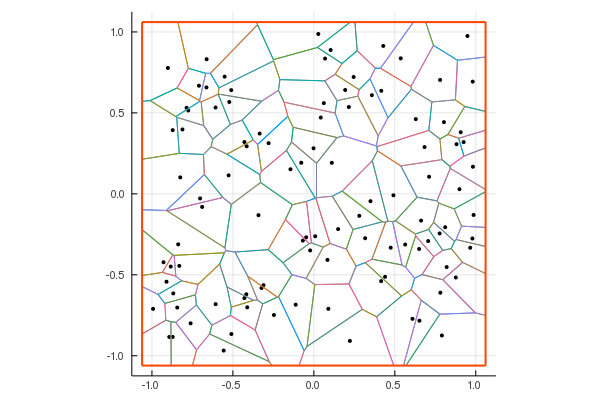

In [19]:
caja = poligono(4, 1.5, π/4 + 10^(-6))

puntos = [[rand(Uniform(-1,1)),rand(Uniform(-1,1))] for i in 1:100]

voronoi = voronoi_fuerza_bruta(puntos, caja)

dibujar_voronoi(voronoi, puntos, caja)

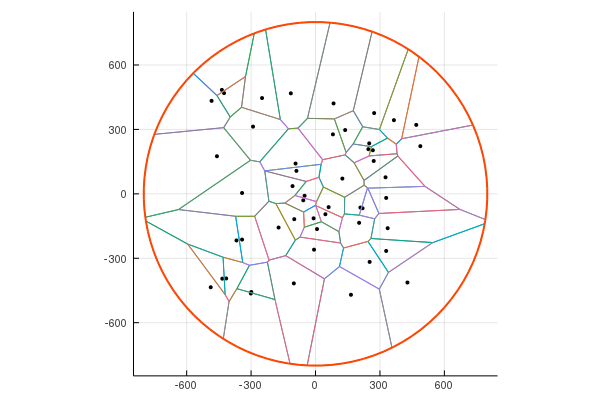

In [14]:
caja = poligono(100, 800, π/4 + 0.0001)

puntos = [[rand(-500:1:500),rand(-500:1:500)] for i in 1:50]

voronoi = voronoi_fuerza_bruta(puntos, caja)

dibujar_voronoi(voronoi, puntos, caja)

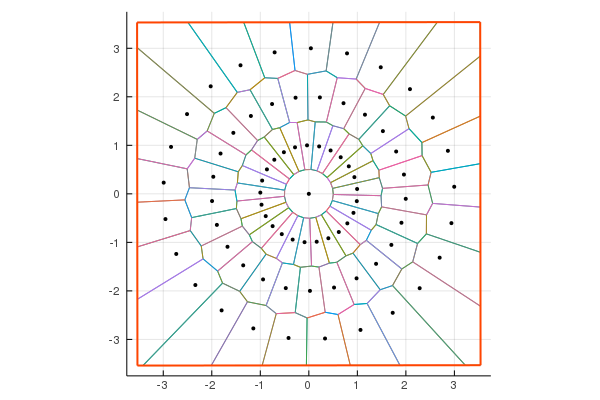

In [15]:
caja = poligono(4, 5, π/4 + 0.001)

puntos = []

push!(puntos, [0.0,0.0])

M = 25

for i in 1:M
    push!(puntos, [cos(2π*i/M + 0.1), sin(2π*i/M + 0.1)])
end

for i in 1:M
    push!(puntos, [2*cos(2π*i/M + 0.2), 2*sin(2π*i/M + 0.2)])
end

for i in 1:M
    push!(puntos, [3*cos(2π*i/M + 0.3), 3*sin(2π*i/M + 0.3)])
end

voronoi = voronoi_fuerza_bruta(puntos, caja)

dibujar_voronoi(voronoi, puntos, caja)

# Voronoi por divide y vencerás

El libro 'Spatial Tesellations. Concepts and Applications of Voronoi Diagrams' de Atsuyuki Okabe en la sección 4.4 tiene una explicación sumamente completa del algoritmo de divide y vencerás para obtener los diagramas de Voronoi